# Import Packages

In [1]:
from keras.models import Sequential, Model
from keras.layers import *
from keras.applications import *
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
from keras.optimizers import RMSprop, SGD, Adam
import keras.backend as K
import tensorflow as tf
from tensorflow.contrib.distributions import Beta
from random import shuffle
from instance_normalization import InstanceNormalization
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


# Configuration

In [2]:
K.set_learning_phase(1)

In [3]:
channel_axis=-1
channel_first = False

#nc_in = 9 # number of input channel
#nc_out = 4 # number of output channel

# ========== Model config ==========
ngf = 64
ndf = 64
use_lsgan = False
λ = 10 if use_lsgan else 100
nc_G_inp = 9 
nc_G_out = 4 
nc_D_inp = 6 
nc_D_out = 1 
gamma_i = 0.1
use_instancenorm = True # False: batchnorm
use_mixup = True
linear_upsampling = False

#==========  conTrainingfig ==========
mixup_alpha = 0.1
imageSize = 256
batchSize = 8
lrD = 2e-4
lrG = 2e-4

# Define Models

In [4]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization

In [5]:
# Source: https://github.com/titu1994/Super-Resolution-using-Generative-Adversarial-Networks/blob/master/models.py
def upscale_block(ip, nf_out):
    '''
    As per suggestion from http://distill.pub/2016/deconv-checkerboard/, I am swapping out
    SubPixelConvolution to simple Nearest Neighbour Upsampling
    '''
    init = ip
    
    if not nf_out == 3:
        x = Conv2D(nf_out, kernel_size=(4,3), strides=1, activation="linear", padding='same', 
                   kernel_initializer=conv_init, use_bias=False)(init)
        x = LeakyReLU(alpha=0.25)(x)
    else:
        x = init
    x = UpSampling2D()(x)
    x = Conv2D(nf_out, kernel_size=(4,3), strides=1, activation="linear", padding='same', 
               kernel_initializer=conv_init, use_bias=False)(x)
    x = LeakyReLU(alpha=0.3)(x)

    return x

In [6]:
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)

def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)

def instance_norm():
    return InstanceNormalization(axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)

# Basic discriminator
def BASIC_D(nc_in, ndf, max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a =  Input(shape=(nc_in, None, None))
    else:
        input_a = Input(shape=(None, None, nc_in))
    _ = input_a
    _ = GaussianNoise(0.05)(_) # ====================
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid" if use_sigmoid else None) (_)    
    return Model(inputs=[input_a], outputs=_)


"""
Unet or Resnet, which one is better for pix2pix model? 
https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/117
Reply from the author:
    UNet gives slightly better results than Resnet in some of the pix2pix applications. 
    We haven't varied the depth of the UNet model, but it might be worth trying.
"""

def UNET_G_dilated256(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True, use_batchnorm=True):
    
    # res_block from cycleGAN-keras (PiscesDream)
    def res_block(inp, ch):
        x = inp
        #x = padding()(x) # reflectPadding2D ?
        x = conv2d(ch, kernel_size=(4,3), strides=1, use_bias=(not (use_batchnorm and s>2)),
                   padding="same") (x)
        if use_instancenorm:
            x = instance_norm()(x, training=1)
        else:
            x = batchnorm()(x, training=1)
        x = Activation('relu')(x)
        #x = padding()(x) 
        x = conv2d(ch, kernel_size=(4,3), strides=1, use_bias=(not (use_batchnorm and s>2)),
                   padding="same") (x)
        if use_instancenorm:
            x = instance_norm()(x, training=1)
        else:
            x = batchnorm()(x, training=1)
        
        x = se_block(x)
        x = add([x, inp])
        return x
    
    def refiner_network(inp, output_channel, res_block_channel=32):
        x = inp
        x = conv2d(res_block_channel, kernel_size=1, strides=1, use_bias=(not (use_batchnorm and s>2)))(x) 
        for i in range(2):
            x = res_block(x, res_block_channel)
        x = conv2d(output_channel, kernel_size=1, strides=1, use_bias=(not (use_batchnorm and s>2)))(x) 
        x = add([x, inp])
        return x
    
    def se_block(input_tensor, compress_rate = 8):
        num_channels = int(input_tensor.shape[-1]) # Tensorflow backend
        bottle_neck = int(num_channels//compress_rate)

        se_branch = GlobalAveragePooling2D()(input_tensor)
        se_branch = Dense(bottle_neck, activation='relu')(se_branch)
        se_branch = Dense(num_channels, activation='sigmoid')(se_branch)

        x = input_tensor 
        out = multiply([x, se_branch])

        return out
            
    
    s = isize if fixed_input_size else None
    _ = inputs = Input(shape=(s, int(s*.75), nc_in))
    x_i = Lambda(lambda x: x[:, :, :, 0:3], name='x_i')(inputs)
    y_j = Lambda(lambda x: x[:, :, :, 6:], name='y_j')(inputs)
    xi_and_yj = concatenate([x_i, y_j], name = 'xi_yj')
    xi_yj_sz128 = AveragePooling2D(pool_size=2)(xi_and_yj) # Using MaxPooling2D increase artifact in output images
    xi_yj_sz64 = AveragePooling2D(pool_size=4)(xi_and_yj)
    
    layer1 = conv2d(64, kernel_size=(4,3), strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'layer1') (_)
    layer1 = LeakyReLU(alpha=0.2)(layer1)
    layer1 = concatenate([layer1, xi_yj_sz128]) 
    layer2 = conv2d(128, kernel_size=(4,3), strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'layer2') (layer1)
    if use_instancenorm:
        layer2 = instance_norm()(layer2, training=1)
    else:
        layer2 = batchnorm()(layer2, training=1)
    layer3 = LeakyReLU(alpha=0.2)(layer2)
    layer3 = concatenate([layer3, xi_yj_sz64])
    layer3 = conv2d(256, kernel_size=(4,3), strides=1, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'layer3') (layer3)
    if use_instancenorm:
        layer3 = instance_norm()(layer3, training=1)
    else:
        layer3 = batchnorm()(layer3, training=1)
    layer4 = LeakyReLU(alpha=0.2)(layer3)
    layer4 = concatenate([layer4, xi_yj_sz64]) 
    layer4 = conv2d(256, kernel_size=(4,3), strides=1, use_bias=(not (use_batchnorm and s>2)), dilation_rate=(2, 2),
                   padding="same", name = 'layer4') (layer4)
    if use_instancenorm:
        layer4 = instance_norm()(layer4, training=1)
    else:
        layer4 = batchnorm()(layer4, training=1)
    layer4 = LeakyReLU(alpha=0.2)(layer4)
    layer4 = concatenate([layer4, xi_yj_sz64]) 
    
    layer5 = LeakyReLU(alpha=0.2)(layer4)
    layer5 = conv2d(256, kernel_size=(4,3), strides=1, use_bias=(not (use_batchnorm and s>2)), dilation_rate=(2, 2),
                   padding="same", name = 'layer5') (layer5)
    if use_instancenorm:
        layer5 = instance_norm()(layer5, training=1)
    else:
        layer5 = batchnorm()(layer5, training=1)    
    layer5 = LeakyReLU(alpha=0.2)(layer5)
    layer5 = concatenate([layer5, xi_yj_sz64]) 
    
    layer8 = Conv2D(256, kernel_size=(4,3), strides=1, use_bias=not use_batchnorm, dilation_rate=(2, 2), padding="same",
                    kernel_initializer = conv_init, name = 'layer8')(layer5) 
    if use_instancenorm:
        layer8 = instance_norm()(layer8, training=1)
    else:
        layer8 = batchnorm()(layer8, training=1)
    layer8 = Activation('relu')(layer8)  
    layer8 = Concatenate(axis=channel_axis)([layer8, layer4])
        
    layer9 = Conv2D(256, kernel_size=(4,3), strides=1, use_bias=not use_batchnorm, dilation_rate=(2, 2), padding="same",
                            kernel_initializer = conv_init, name = 'layer9')(layer8) 
    if use_instancenorm:
        layer9 = instance_norm()(layer9, training=1)
    else:
        layer9 = batchnorm()(layer9, training=1)
    layer9 = Concatenate(axis=channel_axis)([layer9, layer3])
    layer9 = Activation('relu')(layer9)
    layer9 = concatenate([layer9, xi_yj_sz64]) 
    layer10 = Conv2D(128, kernel_size=(4,3), strides=1, use_bias=not use_batchnorm, padding="same",
                            kernel_initializer = conv_init, name = 'layer10')(layer9) 
    if use_instancenorm:
        layer10 = instance_norm()(layer10, training=1)
    else:
        layer10 = batchnorm()(layer10, training=1)
    layer10 = Concatenate(axis=channel_axis)([layer10, layer2])
    layer10 = Activation('relu')(layer10)
    
    # Output branch 0
    out64 = layer10
    out64 = conv2d(4, kernel_size=(4,3), strides=1, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'out64') (out64)
    out64_alpha = Lambda(lambda x: x[:, :, :, 0:1], name='alpha64')(out64)
    out64_x_i_j = Lambda(lambda x: x[:, :, :, 1:], name='x_i_j64')(out64)
    out64_alpha = Activation("sigmoid", name='out64_alpha_sigmoid')(out64_alpha)
    out64_x_i_j = Activation("tanh", name='out64_x_i_j_tanh')(out64_x_i_j)
    out64 = concatenate([out64_alpha, out64_x_i_j], name = 'out64_concat')    
    
    layer10 = concatenate([layer10, xi_yj_sz64])
    layer11 = refiner_network(layer10, 262, res_block_channel=64)
    layer11 = Activation('relu')(layer11)
    if linear_upsampling:
        layer11 = upscale_block(layer11, 64)
    else:
        layer11 = Conv2DTranspose(64, kernel_size=(4,3), strides=2, use_bias=not use_batchnorm,
                                kernel_initializer = conv_init, name = 'layer11')(layer11) 
        layer11 = Cropping2D(((1,1),(1,0)))(layer11)
    
    if use_instancenorm:
        layer11 = instance_norm()(layer11, training=1)
    else:
        layer11 = batchnorm()(layer11, training=1)
    layer11 = Activation('relu')(layer11)
    
    # Output branch 1
    out128 = layer11
    out128 = conv2d(4, kernel_size=(4,3), strides=1, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'out128') (out128)
    out128_alpha = Lambda(lambda x: x[:, :, :, 0:1], name='alpha128')(out128)
    out128_x_i_j = Lambda(lambda x: x[:, :, :, 1:], name='x_i_j128')(out128)
    out128_alpha = Activation("sigmoid", name='out128_alpha_sigmoid')(out128_alpha)
    out128_x_i_j = Activation("tanh", name='out128_x_i_j_tanh')(out128_x_i_j)
    out128 = concatenate([out128_alpha, out128_x_i_j], name = 'out128_concat')
    
    layer12 = concatenate([layer11, xi_yj_sz128])
    layer12 = refiner_network(layer12, 70)
    layer12 = Activation('relu')(layer12)
    if linear_upsampling:
        layer12 = upscale_block(layer12, 32)
    else:
        layer12 = Conv2DTranspose(32, kernel_size=(4,3), strides=2, use_bias=not use_batchnorm,
                                kernel_initializer = conv_init, name = 'layer12')(layer12) 
        layer12 = Cropping2D(((1,1),(1,0)))(layer12)
    
    if use_instancenorm:
        layer12 = instance_norm()(layer12, training=1)
    else:
        layer12 = batchnorm()(layer12, training=1)
    
    # Output branch 2
    layer12 = conv2d(4, kernel_size=(8,6), strides=1, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'out256') (layer12)    
    alpha = Lambda(lambda x: x[:, :, :, 0:1], name='alpha')(layer12)
    x_i_j = Lambda(lambda x: x[:, :, :, 1:], name='x_i_j')(layer12)
    alpha = Activation("sigmoid", name='alpha_sigmoid')(alpha)
    x_i_j = Activation("tanh", name='x_i_j_tanh')(x_i_j)
    out = concatenate([alpha, x_i_j], name = 'out256_concat')
    
    return Model(inputs=inputs, outputs=[out64, out128, out]) 

In [7]:
netGA = UNET_G_dilated256(imageSize, nc_G_inp, nc_G_out, ngf)
netGA.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 192, 9)  0                                            
__________________________________________________________________________________________________
x_i (Lambda)                    (None, 256, 192, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
y_j (Lambda)                    (None, 256, 192, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
layer1 (Conv2D)                 (None, 128, 96, 64)  6912        input_1[0][0]                    
__________________________________________________________________________________________________
xi_yj (Con

In [8]:
netD0 = BASIC_D(nc_D_inp, ndf, use_sigmoid = not use_lsgan)
netD1 = BASIC_D(nc_D_inp, ndf, use_sigmoid = not use_lsgan)
netD2 = BASIC_D(nc_D_inp, ndf, use_sigmoid = not use_lsgan)
netD2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 6)     0         
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, None, None, 6)     0         
_________________________________________________________________
First (Conv2D)               (None, None, None, 64)    6208      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, None, None, 64)    0         
_________________________________________________________________
pyramid.1 (Conv2D)           (None, None, None, 128)   131072    
_________________________________________________________________
batch_normalization_7 (Batch (None, None, None, 128)   512       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, None, None, 128)   0         
__________

# Define Variables

In [9]:
def get_alpha_xij(input_tensor):
    alpha = Lambda(lambda x: x[:,:,:, 0:1])(input_tensor)
    x_i_j = Lambda(lambda x: x[:,:,:, 1:])(input_tensor)    
    return alpha, x_i_j

def get_rec_input(netG, input_tensor256, input_tensor, y_j, y_i, out_idx):
    concat_input_G2 = concatenate([input_tensor256, y_j, y_i], axis=-1) # swap y_i and y_j
    rec_input = netG([concat_input_G2])[out_idx]
    rec_alpha, rec_x_i_j = get_alpha_xij(rec_input)
    rec_input = rec_alpha*rec_x_i_j + (1-rec_alpha)*input_tensor    
    return rec_input

def cycle_variables(netG1):
    """
    Intermidiate params:
        x_i: human w/ cloth i, shape=(256,192,3)
        y_i: stand alone cloth i, shape=(256,192,3)
        y_j: stand alone cloth j, shape=(256,192,3)
        alpha: mask for x_i_j, shape=(256,192,1)
        x_i_j: generated fake human swapping cloth i to j, shape=(256,192,3)
    
    Out:
        real_input: concat[x_i, y_i, y_j], shape=(256,192,9)
        fake_output: masked_x_i_j = alpha*x_i_j + (1-alpha)*x_i, shape=(256,192,3)
        rec_input: output of cyclic loop, shape=(256,192,3)
        idt_input: output of cyclic loop (identity input), shape=(256,192,3)
        fn_generate: a path from input to first G_out(masked) and second G_out(masked)
    """
    real_input = netG1.inputs[0]
    fake_output0 = netG1.outputs[0] # shape=(64,48,4)
    fake_output1 = netG1.outputs[1] # shape=(128,96,4)
    fake_output2 = netG1.outputs[2] # shape=(256,192,4)
    
    x_i = Lambda(lambda x: x[:,:,:, 0:3])(real_input)
    y_i = Lambda(lambda x: x[:,:,:, 3:6])(real_input)
    y_j = Lambda(lambda x: x[:,:,:, 6:])(real_input)
    x_i_size64 = tf.image.resize_images(x_i, [imageSize//4, int(imageSize*0.75)//4])
    x_i_size128 = tf.image.resize_images(x_i, [imageSize//2, int(imageSize*0.75)//2])
    
    alpha0, x_i_j0 = get_alpha_xij(fake_output0)
    alpha1, x_i_j1 = get_alpha_xij(fake_output1)  
    alpha2, x_i_j2 = get_alpha_xij(fake_output2) 
    fake_output0 = alpha0*x_i_j0 + (1-alpha0)*x_i_size64 
    fake_output0_resize256 = tf.image.resize_images(fake_output0, [imageSize, int(imageSize*0.75)])
    fake_output1 = alpha1*x_i_j1 + (1-alpha1)*x_i_size128 
    fake_output1_resize256 = tf.image.resize_images(fake_output1, [imageSize, int(imageSize*0.75)])
    fake_output2 = alpha2*x_i_j2 + (1-alpha2)*x_i 
    
    rec_input_size64 = get_rec_input(netG1, fake_output0_resize256, x_i_j0, y_j, y_i, 0) # Pass x_i_j0 instead of fake_output0 for masking
    rec_input_size128 = get_rec_input(netG1, fake_output1_resize256, fake_output1, y_j, y_i, 1)
    rec_input = get_rec_input(netG1, fake_output2, fake_output2, y_j, y_i, 2)
    
    idt_input = get_rec_input(netG1, x_i, x_i, y_i, y_i, 2)
    
    fn_generate0 = K.function([real_input], [fake_output0, rec_input_size64])
    fn_generate1 = K.function([real_input], [fake_output1, rec_input_size128])
    fn_generate2 = K.function([real_input], [fake_output2, rec_input])
    
    fake_output_list = [fake_output0, fake_output1, fake_output2]
    rec_input_list = [rec_input_size64, rec_input_size128, rec_input]
    fn_generate_list = [fn_generate0, fn_generate1, fn_generate2]
    alpha_list = [alpha0, alpha1, alpha2]
    return real_input, fake_output_list, rec_input_list, fn_generate_list, alpha_list, idt_input

In [10]:
"""
Naming rules for variables:
    _0: tensors from output branch 0
    _1: tensors from output branch 1
    _2: tensors from output branch 2
"""

real, fake_output_list, rec_input_list, fn_generate_list, alpha_list, idt = cycle_variables(netGA)

fake_0, fake_1, fake_2 = fake_output_list
rec_0, rec_1, rec_2 = rec_input_list
cycle0_generate, cycle1_generate, cycle_generate = fn_generate_list
alpha_0, alpha_1, alpha_2 = alpha_list

# Define Loss Function

In [11]:
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

In [12]:
def D_loss(netD, real, fake, rec, alpha=None, idt=None, is_cyclic=False):
    #x_i, y_i, y_j = tf.split(real, [3, 3, 3], 3)    
    x_i = Lambda(lambda x: x[:,:,:, 0:3])(real)
    y_i = Lambda(lambda x: x[:,:,:, 3:6])(real)
    y_j = Lambda(lambda x: x[:,:,:, 6:])(real)
    x_i_j = fake  
    
    dist = Beta(mixup_alpha, mixup_alpha)
    lam = dist.sample()
    
    if use_mixup:
        mixup_x = lam*x_i + (1-lam)*x_i_j
        mixup_y = lam*y_i + (1-lam)*y_j
        output_real = netD(concatenate([mixup_x, mixup_y])) # positive sample + negative sample
        output_fake = netD(concatenate([x_i_j, y_j])) # negative sample (dummy)
        output_fake2 = netD(concatenate([x_i, y_j])) # negative sample 2 
    else:
        output_real = netD(concatenate([x_i, y_i])) # positive sample
        output_fake = netD(concatenate([x_i_j, y_j])) # negative sample
        output_fake2 = netD(concatenate([x_i, y_j])) # negative sample 2
        
    if not alpha is None:
        alpha_resized = tf.image.resize_images(alpha, [int(output_real.shape[1]), int(output_real.shape[2])])   
    else:
        alpha_resized = 1
    
    loss_D_real = loss_fn(output_real, lam*K.ones_like(output_real)) 
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    #loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake) + (1-alpha_resized)*K.ones_like(output_fake))
    loss_D_fake2 = loss_fn(output_fake2, K.zeros_like(output_fake2))   
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))   
    
    if use_mixup:
        loss_D = loss_D_real+ loss_D_fake2
    else:
        loss_D = loss_D_real+ (loss_D_fake+loss_D_fake2)
    
    # cyclic consistency loss
    if is_cyclic:
        loss_cyc = K.mean(K.abs(rec-x_i))
    else:
        loss_cyc = 0
    
    # identity loss
    if not idt is None:
        loss_cyc += K.mean(K.abs(idt-x_i))
        
    return loss_D, loss_G, loss_cyc

def resize_real(x, sz=[128, 96]):   
    x_i = Lambda(lambda x: x[:,:,:, 0:3])(x)
    y_i = Lambda(lambda x: x[:,:,:, 3:6])(x)
    y_j = Lambda(lambda x: x[:,:,:, 6:])(x)
    
    x_i = tf.image.resize_images(x_i, sz)
    y_i = tf.image.resize_images(y_i, sz)
    y_j = tf.image.resize_images(y_j, sz)
    
    out = concatenate([x_i,y_i, y_j])
    return out

def compute_covar(input_tensor, mean, sz = (64,48)):
    m = K.stack([mean]*sz[0], axis=1)
    m = K.stack([m]*sz[1], axis=2)
    var_reshape = K.reshape((input_tensor - m), (-1,3))
    covar = K.dot(K.transpose(var_reshape), var_reshape)
    N = sz[0] * sz[1]
    return covar/N

In [13]:
real_size64 = resize_real(real, sz=[imageSize//4, int(imageSize*0.75)//4])
real_size128 = resize_real(real, sz=[imageSize//2, int(imageSize*0.75)//2])
loss_D0, loss_G0, loss_cyc0 = D_loss(netD0, real_size64, fake_0, rec_0, is_cyclic=True)
loss_D1, loss_G1, loss_cyc1 = D_loss(netD1, real_size128, fake_1, rec_1, is_cyclic=True)
loss_D2, loss_G2, loss_cyc2 = D_loss(netD2, real, fake_2, rec_2, idt, is_cyclic=True)
loss_cyc = loss_cyc0 + loss_cyc1 + loss_cyc2

# loss of alpha mask
loss_id = K.mean(K.abs(alpha_0)) + K.mean(K.abs(alpha_1)) + K.mean(K.abs(alpha_2)) 

# loss - color consistency regularization (StackGan++ Sec. 5.3)
mean_64 = K.mean(fake_0, axis=[1,2])
covar_64 = compute_covar(fake_0, mean_64, sz=(imageSize//4, int(imageSize*0.75)//4))
mean_128 = K.mean(fake_1, axis=[1,2])
covar_128 = compute_covar(fake_1, mean_128, sz=(imageSize//2, int(imageSize*0.75)//2))
mean_256 = K.mean(fake_2, axis=[1,2])
covar_256 = compute_covar(fake_2, mean_256, sz=(imageSize, int(imageSize*0.75)))
lambda1 = 1
lambda2 = 5
loss_C_64_128 = lambda1*K.mean(K.square(mean_128-mean_64)) + lambda2*K.mean(K.square(covar_128-covar_64))
loss_C_128_256 = lambda1*K.mean(K.square(mean_256-mean_128)) + lambda2*K.mean(K.square(covar_256-covar_128))
loss_C = loss_C_64_128 + loss_C_128_256 

loss_G = (loss_G0 + loss_G1 + loss_G2) + 1*(1*loss_cyc + 1*gamma_i*loss_id) + 1*loss_C
loss_D0 = loss_D0*2
loss_D1 = loss_D1*2
loss_D2 = loss_D2*2

weightsD0 = netD0.trainable_weights
weightsD1 = netD1.trainable_weights
weightsD2 = netD2.trainable_weights
weightsG = netGA.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD0,[],loss_D0)
netD0_train = K.function([real],[loss_D0/2], training_updates)
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD1,[],loss_D1)
netD1_train = K.function([real],[loss_D1/2], training_updates)
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD2,[],loss_D2)
netD2_train = K.function([real],[loss_D2/2], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG,[], loss_G)
netG_train = K.function([real], [loss_G, loss_cyc, loss_C], training_updates)

# Load Image

Filenames for training data:

    "./imgs/1/fileID_1.jpg" for human images. 
    "./imgs/5/fileID_5.jpg" for article images.

In [14]:
isRGB = True
apply_da = True

In [15]:
import cv2
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)

def crop_img(img, large_size, small_size):
    # only apply DA on human images
    img_width = small_size[0]
    img_height = small_size[1]
    diff_size = (large_size[0]-small_size[0], large_size[1]-small_size[1])
    
    x_range = [i for i in range(diff_size[0])]
    y_range = [j for j in range(diff_size[1])]
    x0 = np.random.choice(x_range)
    y0 = np.random.choice(y_range)
    
    img = np.array(img)
    
    img = img[y0: y0+img_height, x0: x0+img_width, :]
    
    return img

def read_image(fn, fixed_fn_y_j=None):
    input_size = (int(imageSize*0.75)+30, imageSize+40)
    cropped_size = (int(imageSize*0.75), imageSize)
    
    if isRGB:
    # Load human picture
        im = Image.open(fn).convert('RGB')
        if apply_da is True:
            im = im.resize(input_size, Image.BILINEAR )   
        else:
            im = im.resize(cropped_size, Image.BILINEAR )   
    else:
        im = cv2.imread(fn)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
        if apply_da is True:
            im = cv2.resize(im, input_size, interpolation=cv2.INTER_CUBIC)
        else:
            im = cv2.resize(im, cropped_size, interpolation=cv2.INTER_CUBIC)
    if apply_da is True:
        im = crop_img(im, input_size, cropped_size)
    arr = np.array(im)/255*2-1
    img_x_i = arr
    if channel_first:        
        img_x_i = np.moveaxis(img_x_i, 2, 0)
        
    # Load article picture y_i
    fn_y_i = "5.jpg"
    if isRGB:
        im = Image.open(fn_y_i).convert('RGB')
        im = im.resize(cropped_size, Image.BILINEAR )    
    else:
        im = cv2.imread(fn_y_i)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
        im = cv2.resize(im, cropped_size, interpolation=cv2.INTER_CUBIC)
    arr = np.array(im)/255*2-1
    img_y_i = arr
    if channel_first:        
        img_y_i = np.moveaxis(img_y_i, 2, 0)
    
    # Load article picture y_j randomly
    if fixed_fn_y_j is None:
        fn_y_j = np.random.choice(filenames_5)
    else:
        fn_y_j = fixed_fn_y_j
    while (fn_y_j == fn_y_i):
        fn_y_j = np.random.choice(filenames_5)
    if isRGB:
        im = Image.open(fn_y_j).convert('RGB')
        im = im.resize(cropped_size, Image.BILINEAR )
    else:
        im = cv2.imread(fn_y_j)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
        im = cv2.resize(im, cropped_size, interpolation=cv2.INTER_CUBIC)
    arr = np.array(im)/255*2-1
    img_y_j = arr    
    if randint(0,1): 
        img_y_j=img_y_j[:,::-1]
    if channel_first:        
        img_y_j = np.moveaxis(img_y_j, 2, 0)        
    
    if randint(0,1): # prevent disalign of the graphic on t-shirts and human when fplipping
        img_x_i=img_x_i[:,::-1]
        img_y_i=img_y_i[:,::-1]
    
    img = np.concatenate([img_x_i, img_y_i, img_y_j], axis=-1)    
    assert img.shape[-1] == 9
    
    return img

** Get filenames**

In [16]:
train_A = load_data('./bottoms/*.jpg')

filenames_1 = load_data('./bottoms/*.jpg')
filenames_5 = load_data('./hu/*.jpg')

print(len(train_A))
assert (len(train_A))

31


# Utilities

In [17]:
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None
    shuffle(data)
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1      
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB(dataA, batchsize):
    batchA=minibatch(dataA, batchsize)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        tmpsize = yield ep1, A

In [18]:
def minibatch_demo(data, batchsize, fn_y_i=None):
    length = len(data)
    epoch = i = 0
    tmpsize = None
    shuffle(data)
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1    
        rtn = [read_image(data[j], fn_y_i) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB_demo(dataA, batchsize, fn_y_i=None):
    batchA=minibatch_demo(dataA, batchsize, fn_y_i=fn_y_i)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        tmpsize = yield ep1, A

In [19]:
from IPython.display import display
def showX(X, size=(256,192), rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,128,96), 1, 3)
    else:
        if X.shape[-1] == 9:
            img_x_i = int_X[:,:,:,:3]
            img_y_i = int_X[:,:,:,3:6]
            img_y_j = int_X[:,:,:,6:9]
            int_X = np.concatenate([img_x_i, img_y_i, img_y_j], axis=1)
        else:
            int_X = int_X.reshape(-1, size[0], size[1], 3)
    int_X = int_X.reshape(rows, -1, size[0], size[1], 3).swapaxes(1,2).reshape(rows*size[0],-1, 3)
    if not isRGB:
        int_X = cv2.cvtColor(int_X, cv2.COLOR_LAB2RGB)
    display(Image.fromarray(int_X))

In [20]:
def showG(A):
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]        
    rA = G(cycle_generate, A)
    arr = np.concatenate([A[:,:,:,:3], A[:,:,:,3:6], A[:,:,:,6:9], rA[0], rA[1]])
    showX(arr, (imageSize, int(imageSize*0.75)), 5)  
    rA1 = G(cycle1_generate, A)
    arr1 = np.concatenate([rA1[0], rA1[1]])
    showX(arr1, (imageSize//2, int(imageSize*0.75)//2), 2)      
    rA0 = G(cycle0_generate, A)
    arr0 = np.concatenate([rA0[0], rA0[1]])
    showX(arr0, (imageSize//4, int(imageSize*0.75)//4), 2)    

# Start Training#

In [ ]:
t0 = time.time()
print("hello")
niter = 5
gen_iterations = 0
epoch = 0
errCyc_sum = errGA_sum = errDA_sum = errC_sum = 0

display_iters = 5
train_batch = minibatchAB(train_A, batchSize)

#while epoch < niter: 
while gen_iterations <2:
    print("hello")
    epoch, A = next(train_batch)   
    errDA0  = netD0_train([A])
    errDA1  = netD1_train([A])
    errDA2  = netD2_train([A])
    errDA_sum += errDA2[0]

    errGA, errCyc, errC = netG_train([A])
    errGA_sum += errGA
    errCyc_sum += errCyc
    errC_sum += errC
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        if gen_iterations%(10*display_iters)==0: # clear_output every 500 iters
            clear_output()
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_cyc: %f'
        % (epoch, niter, gen_iterations, errDA_sum/display_iters,
           errGA_sum/display_iters, errCyc_sum/display_iters), time.time()-t0)        
        _, A = train_batch.send(4)
        showG(A)        
        errCyc_sum = errGA_sum = errDA_sum = errC_sum = 0

# Show results on fixed target article

In [22]:
len_fn = len(filenames_5)
idx = np.random.randint(len_fn)

In [23]:
fn = filenames_5[idx]

demo_batch = minibatchAB_demo(train_A, batchSize, fn)
epoch, A = next(demo_batch) 

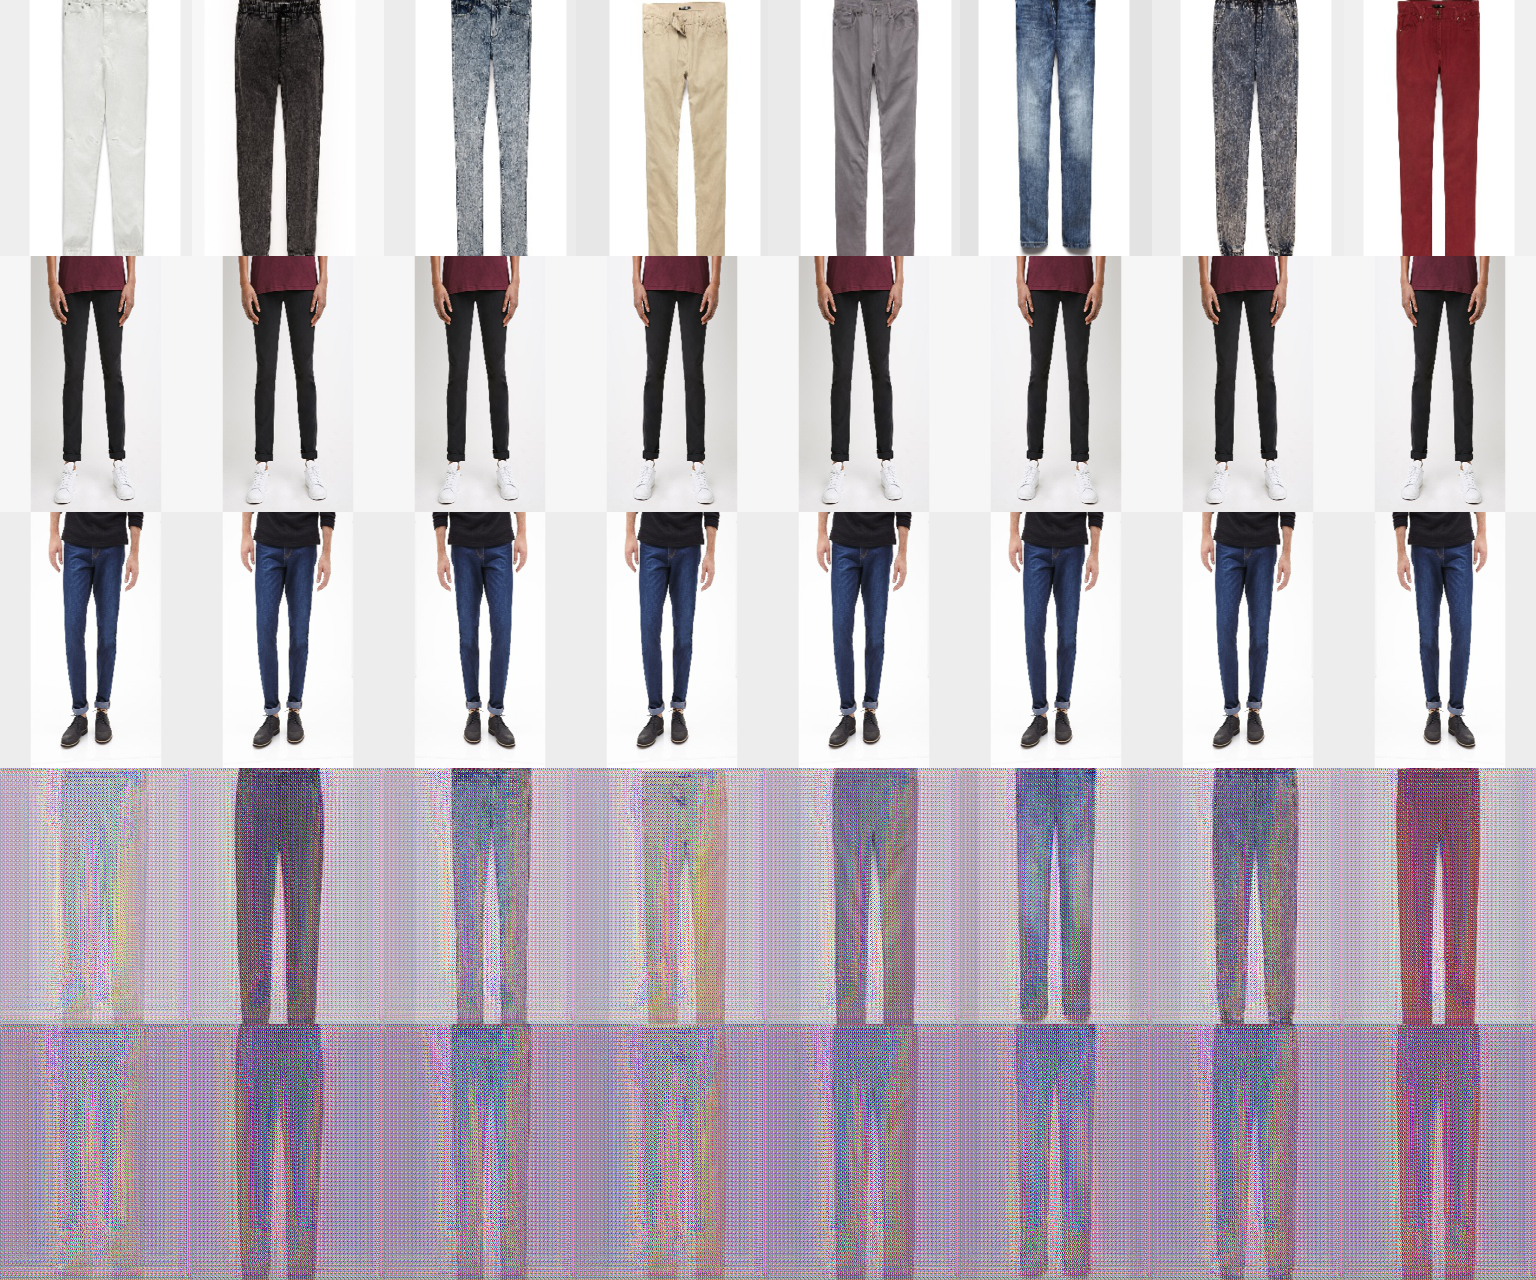

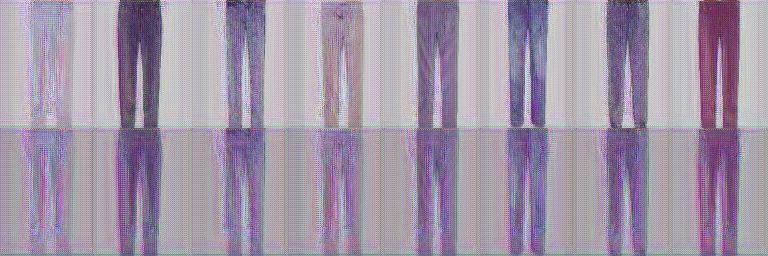

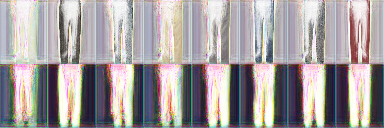

In [24]:
_, A = demo_batch.send(8)
showG(A)